In [1]:
import sys, os
CURRENT_TEST_DIR = os.getcwd()
sys.path.append(CURRENT_TEST_DIR + "/../../../slayerPytorch/src")

In [2]:
import slayerSNN as snn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from joblib import Parallel, delayed
import torch
import copy
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from tas_utils import get_trainValLoader, get_testLoader

np.random.seed(1)
torch.manual_seed(1)

In [16]:
data_dir = '../../new_data_folder/'

train_loader, val_loader, train_dataset, val_dataset = get_trainValLoader(data_dir, k=0)
test_loader, test_dataset = get_testLoader(data_dir)

In [17]:
X_icub, X_bio, _, label= train_dataset[0]

# Spike train slayer

In [123]:
device = torch.device("cuda:1")

In [109]:
# new description
params = {
    "neuron": {
        "type": "SRMALPHA",
        "theta": 5, # 10
        "tauSr": 10.0,
        "tauRef": 2.0,
        "scaleRef": 2,
        "tauRho": 1,
        "scaleRho": 1,
    },
    "simulation": {"Ts": 1.0, "tSample": 75, "nSample": 1}
}

In [124]:
slayer = snn.layer(params["neuron"], params["simulation"]).to(device)

In [ ]:
spike_train_slayer = slayer.spike(input_real_data.reshape([60,1,1,1,75]).to(device))

In [125]:
spike_train_slayer = slayer.spike(input_real_data.reshape([60,1,1,1,75]).to(device))

In [160]:
spike_train_slayer[14]

tensor([[[[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0.]]]], device='cuda:1')

### Spike train log intensity

In [161]:
e = X_icub[14].squeeze()
e.shape

torch.Size([75])

In [162]:
# only nonzero elements
log_e = torch.zeros(e.shape)
log_e[np.where(e > 0)] = torch.log( e[ np.where(e > 0) ] )

In [163]:
# let's create spike
C = 2
p_pos = 1 
p_neg = -1
x_diff = log_e[1:] - log_e[:-1]
brightness_diff = torch.cat( [ log_e[0].reshape(1), x_diff] )

In [164]:
spike_train_pos = torch.zeros(e.shape)
spike_train_neg = torch.zeros(e.shape)
spike_train_pos[brightness_diff >= p_pos*C] = 1
spike_train_neg[brightness_diff <= p_neg*C] = -1

In [165]:
spike_train_pos

tensor([0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.])

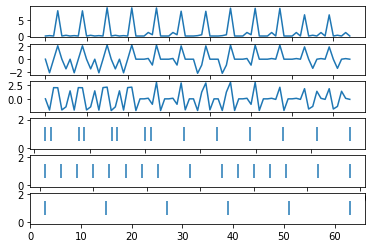

In [167]:
fig, ax = plt.subplots(6)
ax[0].plot(e)
ax[1].plot(log_e)
ax[2].plot(brightness_diff)
ax[3].eventplot(np.where(spike_train_pos == 1))
ax[4].eventplot(np.where(spike_train_neg == -1))
ax[5].eventplot(np.where(spike_train_slayer[14].squeeze().cpu().numpy() == 1))
plt.show()

In [52]:
X = X_icub.squeeze()

In [53]:
X.shape

torch.Size([60, 75])

In [204]:
non_zero_indx = np.where(X > 0)
log_X = torch.zeros(X.shape)
log_X[non_zero_indx] = torch.log( X[ non_zero_indx ] )
x_diff = log_X[:, 1:] - log_X[:, :-1]
brightness_diff = torch.cat([log_X[:,0].reshape([log_X.shape[0],1]),  x_diff], dim=1)

TypeError: where(): argument 'other' (position 3) must be Tensor, not int

In [199]:
x_diff.shape

torch.Size([60, 74])

In [201]:
torch.cat([log_X[:,0].reshape([log_X.shape[0],1]),  x_diff], dim=1).shape

torch.Size([60, 75])

In [184]:
spike_train_pos = np.zeros(X.shape)
spike_train_neg = np.zeros(X.shape)

spike_train_pos[brightness_diff >= p_pos*C] = 1
spike_train_neg[brightness_diff <= p_neg*C] = 1

In [203]:
def get_icub_spike(X):
    
    # parameters
    C = 0.5
    p_pos = 1 
    p_neg = -1
    
    
    X = X.squeeze()
    
    # nonzero elements -> log
    non_zero_indx = np.where(X > 0)
    log_X = torch.zeros(X.shape)
    log_X[non_zero_indx] = torch.log( X[ non_zero_indx ] )
    x_diff = log_X[:, 1:] - log_X[:, :-1]
    brightness_diff = torch.cat([log_X[:,0].reshape([log_X.shape[0],1]),  x_diff], dim=1)
    
    spike_train_pos = torch.zeros(X.shape)
    spike_train_neg = torch.zeros(X.shape)

    spike_train_pos[brightness_diff >= p_pos*C] = 1
    spike_train_neg[brightness_diff <= p_neg*C] = 1
    
    res = torch.cat([spike_train_pos, spike_train_neg])
    
    return res.reshape(res.shape[0],1,1,res.shape[-1])

In [190]:
non_zero_indx = np.where(X > 0)